In [1]:
import PyInventor
from PyInventor import *
import time
import numpy as np


# Welcome to PyInventor

Welcome to PyInventor! The following are a set of demos designed to demonstrate the capabilities of PyInventor. I wrote this with the intent of automating the frustratingly slow process of parametrically varying features in inventor either by hand or using the tedious parameter editor or the built in VBA editor (iLogic). The pyinvent library is a wrapper for the Autodesk Inventor API library which is natively written in VBA (Visual Basic for Applications). Because of this both Autodesk Inventor and this library only work in Microsoft Windows. MacOS is completely incompatible (unless running Windows in bootcamp). 

This package does not require the Schuster Lab Library (slab) to run and can be used with any normal Anaconda 3.2 install or higher with no additional packages. Of course Autodesk Inventor is required. It is recommended that Inventor 2019 is used for best compatibility however this will run using Inventor 2017 or later, however the older variants have not been tested in depth. Anything after Inventor 2019 will also be compatible. For more information on this compatibility and to learn more about the Inventor API and its functionality please refer to the API manual:

http://help.autodesk.com/view/INVNTOR/2019/ENU/

This is version 0.4 of PyInventor and only allows for individual part creation and export. Not all 3D functionality has been added. The following demos demonstrate the current extents of PyInventor's capabilities. New revisions will likely be added in time.

For Slab Users:
________________________________________________________________
To make this work install PyInventor\pyinvent in your "C:\_Lib\slab" directory



If you don't want to use or setup Slab (non-Schusterlab people):
________________________________________________________________
Open a cmd window in the path where the setup.py is located and run: 

>>python setup.py install

Then import PyInventor directly (as is done above)


~AEO

# Contrived geometries and hole features

The first demo is design to demonstrate the most basic functionality of the PyInventor library and demonstrates the main methods by which you create a part. The important thing to note is the basic order of operations for part creation and how it mirrors that of creating an Inventor Part using the GUI Interface. The basic order of operations is:

<img src="Pictures/PyInventor Workflow.png" alt="drawing" width="600">

As can be seen any number of workplanes can be created within a single part document and any number of sketchs can be added to a given workplane and any number of features can be added to a given sketch. Each one of these objects can be manipulated independently and have their own attributes. 

The structure class of PyInventor is the class that allows for user defined shapes. The structure class allows for the creation of new structure objects much in the same way as the vector path drawing functionality of the 2D mask-maker code. Besides keeping track of location within a given structure, the class also creates the necessary Ineventor object attributes. One of these attributes is the close_path functionality, which joins the two end workpoints to ensure that the path is functionally closed. This is important for Inventor to create 3D features. The final structure object is then packaged as an object collection.

For generic shapes like rectangles and circles there are seperate functions within the iPart class. Like the structure object these return an object collection that can then be used to create 3D features. There are also features such as holes (threaded and unthreaded) which can be created. These features return an Inventor object.

The below example demonstrates the basic setup of a 3D part, the use of the structure class, and the creation of a 3D object. It also shows how one can add a threaded hole feature to the pre-existing 3D object.

In [2]:
'''
Non polygonal path and thread hole feature creation
'''

#this line closes all of the open parts
com_obj().close_all_parts()

#set document units
units='imperial'

#set it to overwrite file every time the part is instantiated (REMEMBER TO PUT SAVE AT THE BOTTOM!)
overwrite=True

#filename
fname='arc_test.ipt'

#for demo set the path to path='' to save in current working directory
path='C:\\Users\\Public\\Documents\\Demos'

#setup part document 
part=iPart(path=path, prefix=fname, units=units, overwrite=overwrite)

#create workplane with zero offset on the xy plane
wp=part.add_workplane(plane='xy')

#attach a sketch to the above workplane
sketch_1=part.new_sketch(wp)

#create a new structure, normally uou would give it a start point, however here it is set to (0,0) by default
s=structure(part, sketch_1)
s.add_line(1, 90)
s.add_line_arc(start_angle=0, stop_angle=90, radius=1, flip_dir=True, rotation=0)
s.add_line(1, 180)
s.add_line_arc( start_angle=90, stop_angle=180, radius=1, flip_dir=True, rotation=0)
s.add_line(1, 270)



#creates a closed path from the above structure
test_path=s.draw_path(close_path=True)

#extrude the part
part.extrude(sketch_1, thickness=1, obj_collection=test_path, direction='positive', operation='join')

#hole point location
pt=(-1.5, 0.5)

#add threaded hole feature
part.new_threaded_hole(sketch_1, pos=pt, depth=.5, thread_dia='10', thread_pitch='32', thread_depth=.625, direction='negative')

#save part
part.save();

# save stp part as copy of original
part.save_copy_as(copy_as='stp');


File successfully copied as: C:\Users\Public\Documents\Demos\00003_arc_test.stp


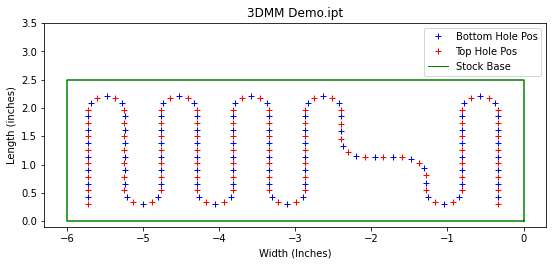

In [7]:
'''
Inventor API test:

In this demo I show how to create the newest iteration of the 3D multimode cavity with one set of holes. 
The other set is exactly the same with a new sketch on an offset workplane and a change in the hole direction.

The way it generates points is using a method similar to how the mask maker works, however because
of the differences in how inventor treats objects (and their relations) there is an added level of complexity
needed to keep track of features and their properties in python.


Just run it and as long as inventor is installed on your computer it should work
'''

#Import plotting libraries for later
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

com_obj().close_all_parts()

#set document units
units='imperial'

#set it to overwrite file every time the part is instantiated (REMEMBER TO PUT SAVE AT THE BOTTOM!)
overwrite=True

#filename
fname='3DMM Demo.ipt'

#path
path='C:\\Users\\Public\\Documents\\Demos'

#setup part 
part=iPart(path=path, prefix=fname, units=units, overwrite=overwrite)

#set view as shaded with edges
part.set_visual_style(shaded=True, edges=True, hidden_edges=False)

#design parameters for the storage cavity top holes
bend_rad=.2375
num_segs=4
spacing=.2375
shift_num=1
shift=shift_num*spacing
num_pts_1=8
num_pts_2=7
#setup first bend radius info
first_bend_rad=.31666666

dist_1=num_pts_1*spacing-shift
dist_2=num_pts_2*spacing-shift

hole_dia=.1875

#setup starting point for holes
hole_start=(-.3375, .30825)


#set origin
stock_origin=(0,0)

#set some basic stock parameters
stock_width=6
stock_length=2.5

#set stock height
H_stock=2.25

#set starting workplane
lower_wp=part.add_workplane(plane='xy')

#attach a sketch to the workplane
sketch_1=part.new_sketch(lower_wp)

#set upper workplane
upper_wp=part.add_workplane(plane='xy', offset=H_stock)

#attach a sketch to the upper workplane
sketch_2=part.new_sketch(upper_wp)

#create stock base associated with sketch 1. The structuire object keeps track of position
stock_base=structure(part, sketch_1, start=stock_origin)

stock_base.add_line(stock_width, 180)
stock_base.add_line(stock_length, 90)
stock_base.add_line(stock_width, 0)

#structure identifier
base_shape=stock_base.draw_path(close_path=True)

#extrude base shape. It is important to set the object collection (obj_collection) to the specific polygon shape we created
base_extrusion=part.extrude(sketch_1, thickness=H_stock, obj_collection=base_shape, direction='positive', operation='join')

#fits whole cavity in frame
part.view.Fit()

#structure identifier
cav_holes_top=structure(part, sketch_1, start=hole_start)

#calculate cumulative distance
cum_dist=dist_1+5*dist_2+np.pi*5*bend_rad+hole_dia

#start drawing points for top holes
cav_holes_top.add_point_line(distance=dist_1 , direction=90, num_points=num_pts_1)   
cav_holes_top.add_point_arc(start_angle=0, stop_angle=180, radius=bend_rad, segments=num_segs, flip_dir=True, rotation=0)

#start drawing points for top holes
cav_holes_top.add_point_line(distance=dist_2 , direction=270, num_points=num_pts_2)   
cav_holes_top.add_point_arc(start_angle=180, stop_angle=0, radius=bend_rad, segments=num_segs, flip_dir=False, rotation=180)


cav_holes_top.add_point_line(distance=1.1111111*spacing , direction=90, num_points=2)   
cav_holes_top.add_point_arc(start_angle=0, stop_angle=90, radius=first_bend_rad, segments=3, flip_dir=True, rotation=0)

cav_holes_top.add_point_line(distance=2*spacing , direction=180, num_points=3)   
cav_holes_top.add_point_arc(start_angle=90, stop_angle=0, radius=first_bend_rad, segments=3, flip_dir=False, rotation=180)

cav_holes_top.add_point_line(distance=2*(1.1111111*spacing) , direction=90, num_points=3)  
cav_holes_top.add_point_arc(start_angle=0, stop_angle=180, radius=bend_rad, segments=num_segs, flip_dir=True, rotation=0)

#start drawing points for top holes

for i in range(0,3):
    cav_holes_top.add_point_line(distance=dist_2 , direction=270, num_points=num_pts_2)   
    cav_holes_top.add_point_arc(start_angle=180, stop_angle=0, radius=bend_rad, segments=num_segs, flip_dir=False, rotation=180)

    cav_holes_top.add_point_line(distance=dist_2 , direction=90, num_points=num_pts_2)   
    cav_holes_top.add_point_arc(start_angle=0, stop_angle=180, radius=bend_rad, segments=num_segs, flip_dir=True, rotation=0)

cav_holes_top.add_point_line(distance=dist_1 , direction=270, num_points=num_pts_1)   

#set new starting position of bottom holes
bot_hole_start=(hole_start[0], hole_start[1]+spacing/2)

# #create new structure representing bottom holes attached to bottom workplane
cav_holes_bot=structure(part, sketch_2,  start=bot_hole_start)

new_dist_2=dist_2-spacing
new_num_pts_2=int(new_dist_2/spacing)+2

new_dist_1=dist_1-spacing
new_num_pts_1=int(new_dist_1/spacing)+2

#start drawing points for bottom holes
cav_holes_bot.add_point_line(distance=new_dist_1 , direction=90, num_points=new_num_pts_1) 
cav_holes_bot.move(spacing/2, cav_holes_bot.last_dir)
row_1_x=cav_holes_bot.last[0]

cav_holes_bot.add_point_arc(start_angle=30, stop_angle=180-30, radius=bend_rad,  segments=num_segs-1, flip_dir=True, rotation=0)
cav_holes_bot.move(spacing, 270)
cav_holes_bot.move((row_1_x-bend_rad*2)-cav_holes_bot.last[0], 0)

cav_holes_bot.add_point_line(distance=new_dist_2 , direction=270, num_points=new_num_pts_2)
cav_holes_bot.move(spacing/2, cav_holes_bot.last_dir)
row_2_x=cav_holes_bot.last[0]

cav_holes_bot.add_point_arc(start_angle=180-30, stop_angle=30, radius=bend_rad, segments=3, mirror=True, rotation=180)
cav_holes_bot.move(spacing/2, 90)
cav_holes_bot.move((row_2_x-bend_rad*2)-cav_holes_bot.last[0], 0)

cav_holes_bot.add_point(offset=(0, (1.11111*spacing)/2), ref_pt=None)

cav_holes_bot.move((1.11111*spacing)/2, 90)

ref_pt=cav_holes_bot.last
odd_pts=arc_pattern(90,  0, first_bend_rad, center_pt=(-first_bend_rad,0), segments=5)

cav_holes_bot.add_point(offset=odd_pts[3], ref_pt=ref_pt)
cav_holes_bot.add_point(offset=odd_pts[1], ref_pt=ref_pt)

cav_holes_bot.move(spacing, 180)
cav_holes_bot.move(-(cav_holes_bot.last[1]-(ref_pt[1]+odd_pts[0][1])) , 90)

cav_holes_bot.add_point_line(distance=spacing , direction=180, num_points=2)   

cav_holes_bot.move((spacing)/2, 180)

ref_pt=cav_holes_bot.last

odd_pts=arc_pattern(180,  90, first_bend_rad, center_pt=(0, -first_bend_rad), segments=5)

cav_holes_bot.add_point(offset=(odd_pts[3][0],-odd_pts[3][1]), ref_pt=ref_pt)
cav_holes_bot.add_point(offset=(odd_pts[1][0], -odd_pts[1][1]), ref_pt=ref_pt)

cav_holes_bot.move((cav_holes_bot.last[0]-(ref_pt[0]+odd_pts[0][0])) , 180)
cav_holes_bot.move(1.111111*spacing, 90)

cav_holes_bot.add_point_line(distance=1.11111*spacing , direction=90, num_points=2)  
cav_holes_bot.move(spacing/2, cav_holes_bot.last_dir)
row_1_x=cav_holes_bot.last[0]

cav_holes_bot.add_point_arc(start_angle=30, stop_angle=180-30, radius=bend_rad,  segments=num_segs-1, flip_dir=True, rotation=0)
cav_holes_bot.move(spacing, 270)
cav_holes_bot.move((row_1_x-bend_rad*2)-cav_holes_bot.last[0], 0)

cav_holes_bot.add_point_line(distance=new_dist_2 , direction=270, num_points=new_num_pts_2)
cav_holes_bot.move(spacing/2, cav_holes_bot.last_dir)
row_2_x=cav_holes_bot.last[0]

cav_holes_bot.add_point_arc(start_angle=180-30, stop_angle=30, radius=bend_rad, segments=3, mirror=True, rotation=180)
cav_holes_bot.move(spacing, 90)
cav_holes_bot.move((row_2_x-bend_rad*2)-cav_holes_bot.last[0], 0)
    
cav_holes_bot.add_point_line(distance=new_dist_2 , direction=90, num_points=new_num_pts_2) 
cav_holes_bot.move(spacing/2, cav_holes_bot.last_dir)
row_1_x=cav_holes_bot.last[0]

cav_holes_bot.add_point_arc(start_angle=30, stop_angle=180-30, radius=bend_rad,  segments=num_segs-1, flip_dir=True, rotation=0)
cav_holes_bot.move(spacing, 270)
cav_holes_bot.move((row_1_x-bend_rad*2)-cav_holes_bot.last[0], 0)

cav_holes_bot.add_point_line(distance=new_dist_2 , direction=270, num_points=new_num_pts_2)
cav_holes_bot.move(spacing/2, cav_holes_bot.last_dir)
row_2_x=cav_holes_bot.last[0]

cav_holes_bot.add_point_arc(start_angle=180-30, stop_angle=30, radius=bend_rad, segments=3, mirror=True, rotation=180)
cav_holes_bot.move(spacing, 90)
cav_holes_bot.move((row_2_x-bend_rad*2)-cav_holes_bot.last[0], 0)
    
cav_holes_bot.add_point_line(distance=new_dist_2 , direction=90, num_points=new_num_pts_2) 
cav_holes_bot.move(spacing/2, cav_holes_bot.last_dir)
row_1_x=cav_holes_bot.last[0]

cav_holes_bot.add_point_arc(start_angle=30, stop_angle=180-30, radius=bend_rad,  segments=num_segs-1, flip_dir=True, rotation=0)
cav_holes_bot.move(spacing, 270)
cav_holes_bot.move((row_1_x-bend_rad*2)-cav_holes_bot.last[0], 0)

cav_holes_bot.add_point_line(distance=new_dist_2 , direction=270, num_points=new_num_pts_2)
cav_holes_bot.move(spacing/2, cav_holes_bot.last_dir)
row_2_x=cav_holes_bot.last[0]

cav_holes_bot.add_point_arc(start_angle=180-30, stop_angle=30, radius=bend_rad, segments=3, mirror=True, rotation=180)
cav_holes_bot.move(spacing, 90)
cav_holes_bot.move((row_2_x-bend_rad*2)-cav_holes_bot.last[0], 0)
    
cav_holes_bot.add_point_line(distance=new_dist_2 , direction=90, num_points=new_num_pts_2) 
cav_holes_bot.move(spacing/2, cav_holes_bot.last_dir)
row_1_x=cav_holes_bot.last[0]

cav_holes_bot.add_point_arc(start_angle=30, stop_angle=180-30, radius=bend_rad,  segments=num_segs-1, flip_dir=True, rotation=0)
cav_holes_bot.move(spacing, 270)
cav_holes_bot.move((row_1_x-bend_rad*2)-cav_holes_bot.last[0], 0)

cav_holes_bot.add_point_line(distance=new_dist_1 , direction=270, num_points=new_num_pts_1)
cav_holes_bot.move(spacing/2, cav_holes_bot.last_dir)
row_2_x=cav_holes_bot.last[0]

#create hole features
holes=[]
pos_upper=cav_holes_top.get_pts()[0]
pos_lower=cav_holes_bot.get_pts()[0]
upper_ind=0
lower_ind=0


#create parametric equation for hole depths
def depth_func(H_start, H_final, H_stock, num_pts, p):
    t=np.linspace(0,1, num_pts)
    H_c=param_eqn(t, p, H_start, H_final)
    return (H_c+H_stock)/2

def param_eqn(t, p, H_start, H_final):
    return (H_start)-((H_start-H_final))*t**p

#define parametric hole parameters
H_start=1.25
H_final=H_start/1.1
p=2.5
tot_num_pts=len(cav_holes_top.get_pts()[0])+len(cav_holes_top.get_pts()[0])

#calculate depths for each of the holes, returns a list of depth values that is length of number of holes
hole_depths=depth_func(H_start, H_final, H_stock, tot_num_pts, p)

for I, depth in enumerate(hole_depths):
    if I%2==1:
        if lower_ind<=len(pos_lower)-1:
            holes.append(part.new_hole(cav_holes_bot.sketch, pos_lower[lower_ind], hole_dia, depth, direction='positive', FlatBottom=False, BottomTipAngle=None))
            lower_ind+=1
        else:
            pass
    elif I%2==0:
        if upper_ind<=len(pos_upper)-1:
            holes.append(part.new_hole(cav_holes_top.sketch, pos_upper[upper_ind], hole_dia, depth, direction='negative', FlatBottom=False, BottomTipAngle=None))
            upper_ind+=1
        else:
            pass

        
#For fun lets plot the hole locations to show the layout without looking at Inventor
plot_scale=1.5
plt.figure(figsize=(stock_width*plot_scale, stock_length*plot_scale))
for pt in pos_upper:
    plt.plot(pt[0], pt[1],  '+r')
for pt in pos_lower:
    plt.plot(pt[0], pt[1],  '+b')

stock_pts=stock_base.get_line_pts()[0]
    
stock_x_pos=[]
stock_y_pos=[]
for pos in stock_pts:
    stock_x_pos.append(pos[0])
    stock_y_pos.append(pos[1])


plt.plot(stock_x_pos, stock_y_pos, '-g', label='Stock base')
plt.legend(loc=1)
colors = ['blue', 'red']
lines = [Line2D([0], [0], color=c, linewidth=1, marker='+', linestyle='') for c in colors]
labels = ['Bottom Hole Pos', 'Top Hole Pos']

labels.append('Stock Base')
lines.append(Line2D([0], [0], color='green', linewidth=1, linestyle='-'))

plt.legend(lines, labels, loc=1)
plt.xlabel('Width (Inches)')
plt.ylabel('Length (inches)')
plt.title(fname)
plt.ylim([min(stock_y_pos)-.1, max(stock_y_pos)+1] )
plt.show()

# # Save document 
# part.save();

# #save copy as stp file for export to HFSS
# part.save_copy_as(copy_name='3DMM Demo.stp' );

In [ ]:
'''
Coaxial cavity example showing the use of the revolve command.
'''

#function that closes open files. Useful if you are trying to troubleshoot and don't want to
#keep opening new files every time.
com_obj().close_all_parts()

#set document units
units='imperial'

#set it to overwrite file every time the part is instantiated (REMEMBER TO PUT SAVE AT THE BOTTOM!)
overwrite=True

#filename
fname='Coax Demo.ipt'

#path
path='C:\\Users\\Public\\Documents\\Demos'

#setup part 
part=iPart(path=path, prefix=fname, units=units, overwrite=overwrite)

#set view as wireframe with hidden edges
part.set_visual_style(shaded=False, edges=True, hidden_edges=True)


#create workplane for the revolved sketch
revolve_wp=part.add_workplane(plane='xy')

#create workplane for the stock. Notice that teh revolved feature plane is perpendicular to this
stock_wp=part.add_workplane(plane='xz', offset=2)

#create a sketch for the stock top
stock_sketch=part.new_sketch(stock_wp)

#create a new sketch for the revolved feature geometry
revolve_sketch=part.new_sketch(revolve_wp)

#create a structure for the revolved feature geometry. Notice the starting point
s=structure(part, revolve_sketch, start=(0 ,2))

#draw the outline of the cavity interior. Only 1/2 has to be drawn
s.add_line(.3, 180)
s.add_line(1.85, 270)
s.add_line_arc(start_angle=180, stop_angle=0, radius=.094, flip_dir=True, rotation=0)
s.add_line(.231, 90)
s.add_line_arc(start_angle=0, stop_angle=270, radius=.0625, flip_dir=False, rotation=180)
s.add_line(.038+.0115, 0)

#draw path in the inventor file. Path must be closed for the proper revolution
rev_path=s.draw_path(close_path=True)

#draw the circle that defines the stock diameter. Return object collection that can be used to 
#select in the extrussion step
stock_top_circle=part.sketch_circle(stock_sketch, center=(0,0), radius=.5)

#Extrude part. Notice we are explicitely selecting the circle object from this sketch
re=part.extrude(stock_sketch, thickness=2, obj_collection=stock_top_circle, direction='negative', operation='join')

#Now that there is a solid to reolve a part out of, we can rotate the cavity interior geometry
#The revolution axis must be in plane with the xy plane. In are case we select the y axis. Here
#the axis is set at y=0, however an arbitrary axis can be set
rv=part.revolve_full(revolve_sketch, axis='y', obj_collection=rev_path, operation='cut')

#set final view to GoHome for stylistic effect
time.sleep(2)
part.view.GoHome()

# #Save document 
part.save();

#save copy as stp file for export to HFSS
part.save_copy_as(copy_name='Coax Demo.stp');

In [ ]:
'''
In this demo we show how to revolve around an arbitrary axis as defined by a sketch line to make
and off-axis donut
'''
com_obj().close_all_parts()

#set document units
units='imperial'

#set it to overwrite file every time the part is instantiated (REMEMBER TO PUT SAVE AT THE BOTTOM!)
overwrite=True

#filename
fname='Half Off-Axis Donut Revolve Demo.ipt'

#path
path='C:\\Users\\Public\\Documents\\Demos'

#setup part 
part=iPart(path=path, prefix=fname, units=units, overwrite=overwrite)

center=(0,1)
radius=.2

#set starting workplane
lower_wp=part.add_workplane(plane='xy')

#attach a sketch to the workplane
sketch_1=part.new_sketch(lower_wp)

circle=part.sketch_circle(sketch_1, center, radius)

#new work axes defined by sketch_line that is still in plane
new_rot_axis=part.sketch_line(sketch_1, (0, 0), (.25,.5))

#revolve donut
part.revolve_ang(sketch_1, angle=180, axis=new_rot_axis, obj_collection=circle, operation='join', direction='positive');

# #Save document 
part.save();

#save copy as stp file for export to HFSS
part.save_copy_as(copy_name='Half Off-Axis Donut Revolve Demo.stp' );

In [ ]:
'''
In this demo we show how to make a cylindrical flute style cavity
'''
com_obj().close_all_parts()

#set document units
units='imperial'

#set it to overwrite file every time the part is instantiated (REMEMBER TO PUT SAVE AT THE BOTTOM!)
overwrite=True

#filename
fname='Cylindrical Flute Demo.ipt'

#path
path='C:\\Users\\Public\\Documents\\Demos'

#setup part 
part=iPart(path=path, prefix=fname, units=units, overwrite=overwrite)


#set view as wireframe with hidden edges
part.set_visual_style(shaded=False, edges=True, hidden_edges=True)

#set view from side
part.view.GoHome()

center=(0,0)
radius=1
height=2.125

#set starting workplane
lower_wp=part.add_workplane(plane='xy')

#set hole workplane
#First set
hole_wp_1=part.add_workplane(plane='yz', offset=radius)
#second set
hole_wp_2=part.add_workplane(plane='yz', offset=-radius)

#attach a sketch to the workplane
sketch_1=part.new_sketch(lower_wp)

circle=part.sketch_circle(sketch_1, center, radius)

ext1=part.extrude(sketch_1, thickness=height, obj_collection=circle, direction='positive', operation='join')

#fits whole cavity in frame
part.view.Fit()

#Universal Hole Parameters: Play around with them and see how things change
z_spacing=.2375
num_holes=11
hole_depth=1.25
hole_dia=.1875

#create sketch and hole location on first side
hole_sketch_1=part.new_sketch(hole_wp_1)
num_rows=7
z_start=z_spacing*((height-num_rows*(z_spacing)))+hole_dia/2
hole_locs_1=structure(part, hole_sketch_1, start=(0,z_start))

hole_locs_1.add_point_line(distance=num_rows*z_spacing, direction=90, num_points=num_rows)

hole_coll_1=part.new_obj_collection()
for pts in hole_locs_1.get_pts()[0]:
    hole=part.new_hole(hole_sketch_1, pts, hole_dia, hole_depth, direction='positive', FlatBottom=False, BottomTipAngle=None)
    hole_coll_1.Add(hole)
    
cp=part.circular_feature_pattern(obj_collection=hole_coll_1, count=num_holes, angle=360, axis='z', axis_dir=True, fit_within_ang=True)

#create sketch and hole location on second side
hole_sketch_2=part.new_sketch(hole_wp_2)
num_rows_2=6
z_start_2=z_start+z_spacing/2
hole_locs_2=structure(part, hole_sketch_2, start=(0,z_start_2))

hole_locs_2.add_point_line(distance=num_rows_2*z_spacing, direction=90, num_points=num_rows_2)

hole_coll_2=part.new_obj_collection()
for pts in hole_locs_2.get_pts()[0]:
    hole=part.new_hole(hole_sketch_2, pts, hole_dia, hole_depth, direction='negative', FlatBottom=False, BottomTipAngle=None)
    hole_coll_2.Add(hole)
    
cp=part.circular_feature_pattern(obj_collection=hole_coll_2, count=num_holes, angle=360, axis='z', axis_dir=True, fit_within_ang=True)

#Save document 
part.save()

#save copy as stp file for export to HFSS
part.save_copy_as(copy_name='Cylindrical Flute Demo.stp' );

In [14]:
'''
In this demo we show how to make lattice of cavities
'''
com_obj().close_all_parts()

#set document units
units='imperial'

#set it to overwrite file every time the part is instantiated (REMEMBER TO PUT SAVE AT THE BOTTOM!)
overwrite=True

#filename
fname='Cavity Lattice Demo.ipt'

#path
path='C:\\Users\\Public\\Documents\\Demos'

#setup part 
part=iPart(path=path, prefix=fname, units=units, overwrite=overwrite)

#set view as shaded with edges
part.set_visual_style(shaded=True, edges=True, hidden_edges=False)

#cavity parameters
cav_width=1.0
cav_corner_rad=.25
pin_dia=.125
pin_height=.25
pin_spacing=.25
cav_depth=1.5
cav_edge_len=cav_width-2*cav_corner_rad

#square lattice dim
side_cav_num=5

#stock clearances
cav_spacing=.125
edge_spacing=.25
stock_z_offset=.25

#cavity coupler parameters
coupler_width=.125
coupler_len=.375
coupler_depth=.125

#setup stock
stock_width=cav_width*side_cav_num+cav_spacing*(side_cav_num-1)+2*edge_spacing
stock_height=cav_depth+stock_z_offset
stock_origin=(0,0)

#setup workplanes
stock_wp=part.add_workplane(plane='xy')
cav_bottom_wp=part.add_workplane(plane='xy', offset=stock_z_offset)

#setup sketches
stock_sketch=part.new_sketch(stock_wp)
cav_sketch=part.new_sketch(cav_bottom_wp)

#draw stock
stock_base=structure(part, stock_sketch, start=stock_origin)
stock_base.add_line(stock_width, 180)
stock_base.add_line(stock_width, 90)
stock_base.add_line(stock_width, 0)

stock_path=stock_base.draw_path(close_path=True)

#extrude stock
part.extrude(stock_sketch, thickness=stock_height, obj_collection=stock_path, direction='positive', operation='join')

#fits whole cavity in frame
part.view.Fit()


#create empty list that makes up all the 3D objects of the cavity for later. Notice that the coupl
cav_objects=[]
x_coupler_obj=[]
y_coupler_obj=[]

#create coupler objects, one for x and one for y. First create origins. We will use a centerpoint slot for this
slot_x_center=(stock_origin[0]-edge_spacing-cav_width-cav_spacing/2, stock_origin[1]+edge_spacing+cav_width/2)
slot_x_end=(slot_x_center[0]+coupler_len/2-coupler_width/2, slot_x_center[1])

#create y slot for coupler object
slot_y_center=(stock_origin[0]-edge_spacing-cav_width/2, stock_origin[1]+edge_spacing+cav_width+cav_spacing/2)
slot_y_end=(slot_y_center[0], slot_y_center[1]+coupler_len/2-coupler_width/2)

#create sketch slots for x and y
x_slot=part.sketch_center_slot(stock_sketch, center=slot_x_center, end=slot_x_end, width=coupler_width)
y_slot=part.sketch_center_slot(stock_sketch, center=slot_y_center, end=slot_y_end, width=coupler_width)

#make the stock sketch visable for editing
stock_sketch.sketch_obj.Visible=True

# extrude the x couplers
x_coupler_obj.append(part.extrude(stock_sketch, thickness=stock_z_offset+coupler_depth, obj_collection=x_slot, direction='positive', operation='cut'))
y_coupler_obj.append(part.extrude(stock_sketch, thickness=stock_z_offset+coupler_depth, obj_collection=y_slot, direction='positive', operation='cut'))

#draw cavity shape
cav_origin=(stock_origin[0]-edge_spacing, stock_origin[1]+edge_spacing+cav_corner_rad)
cavity_base=structure(part, cav_sketch, start=cav_origin)
cavity_base.add_line(cav_edge_len, 90)
cavity_base.add_line_arc(start_angle=0, stop_angle=90, radius=cav_corner_rad, flip_dir=True, rotation=0)
cavity_base.add_line(cav_edge_len, 180)
cavity_base.add_line_arc(start_angle=90, stop_angle=180, radius=cav_corner_rad, flip_dir=True, rotation=0)
cavity_base.add_line(cav_edge_len, 270)
cavity_base.add_line_arc(start_angle=0, stop_angle=270, radius=cav_corner_rad, flip_dir=True, rotation=0)
cavity_base.add_line(cav_edge_len, 0)
cavity_base.add_line_arc(start_angle=90, stop_angle=0, radius=cav_corner_rad, flip_dir=True, rotation=0)

cav_base=cavity_base.draw_path(close_path=True)

#extrude and add to cav_objects list for later patterning
cav_objects.append(part.extrude(cav_sketch, thickness=cav_depth, obj_collection=cav_base, direction='positive', operation='cut'))

#pin origin (center of pin pattern)
pin_origin=(stock_origin[0]-edge_spacing-cav_width/2, stock_origin[1]+edge_spacing+cav_width/2)

#create a set of points to define the 3 pin centers based on the spacing and the offset. Equilateral triangle with sides=.25
pin_rot_offset=90
rot_rad=pin_spacing/np.sqrt(3)
pin_pts=circle_pattern(radius=rot_rad, center_pt=pin_origin, segments=3, offset=pin_rot_offset)

#create sketches circles for pins and add to object
pin_obj=[]
for pts in pin_pts:
    pin_obj.append(part.sketch_circle(cav_sketch, center=pts, radius=pin_dia/2))


#because we did one extrude operation we need to make sure the sketch is visable before we try to extrude the pins
cav_sketch.sketch_obj.Visible=True

#extrude pins
for pins in pin_obj:
    cav_objects.append(part.extrude(cav_sketch, thickness=pin_height, obj_collection=pins, direction='positive', operation='join'))

#create an object collection from the above list of extruded features that make up a single cell
cav_obj_coll=part.create_obj_collection(cav_objects)

#pattern feature from the above cavity object collection
x_cav_feat=part.rectangular_feature_pattern(obj_collection=cav_obj_coll, count=side_cav_num, spacing=cav_spacing+cav_width, axis='x', direction='negative', fit_within_len=False)

#add the x new patterned features to the object collection and then repeat the above, now with the updated collection 
#and in the +y direction
cav_obj_coll.Add(x_cav_feat)
y_cav_feat=part.rectangular_feature_pattern(obj_collection=cav_obj_coll, count=side_cav_num, spacing=cav_spacing+cav_width, axis='y', direction='positive', fit_within_len=False)

#repeat for the couplers
x_coupler_coll=part.create_obj_collection(x_coupler_obj)
y_coupler_coll=part.create_obj_collection(y_coupler_obj)

x_coupler_feat_x_pattern=part.rectangular_feature_pattern(obj_collection=x_coupler_coll, count=side_cav_num-1, spacing=cav_spacing+cav_width, axis='x', direction='negative', fit_within_len=False)
x_coupler_coll.Add(x_coupler_feat_x_pattern)
x_coupler_feat_y_pattern=part.rectangular_feature_pattern(obj_collection=x_coupler_coll, count=side_cav_num, spacing=cav_spacing+cav_width, axis='y', direction='positive', fit_within_len=False)

y_coupler_feat_x_pattern=part.rectangular_feature_pattern(obj_collection=y_coupler_coll, count=side_cav_num, spacing=cav_spacing+cav_width, axis='x', direction='negative', fit_within_len=False)
y_coupler_coll.Add(y_coupler_feat_x_pattern)
y_coupler_feat_y_pattern=part.rectangular_feature_pattern(obj_collection=y_coupler_coll, count=side_cav_num-1, spacing=cav_spacing+cav_width, axis='y', direction='positive', fit_within_len=False)

#turn off the cav_sketch visability
cav_sketch.sketch_obj.Visible=False
stock_sketch.sketch_obj.Visible=False

#set final view to GoHome for stylistic effect
time.sleep(2)
part.view.GoHome()

#Save document 
part.save()

#save copy as stp file for export to HFSS
part.save_copy_as(copy_name='Cavity Lattice Demo.stp' );

#spit out our total cavity dimensions
print('Stock size is WxLxH:%.2fx%.2fx%.2f inch'%(stock_width,stock_width,stock_height))

File successfully copied as: C:\Users\Public\Documents\Demos\00001_Cavity Lattice Demo.stp
Stock size is WxLxH:6.00x6.00x1.75 inch
